In [1]:
import pandas as pd
import numpy as np
from pycaret.classification import * # Machine learning tools
from sklearn.metrics import ConfusionMatrixDisplay # Model evaluation
import matplotlib.pyplot as plt # Visualization
import seaborn as sns
from sklearn.metrics import classification_report # Model evaluation report
from sklearn.metrics import confusion_matrix


In [4]:
training_data = pd.read_excel('/home/dsg/vortex/PRODUCTION/DATA/processed/training_data.xlsx', engine='openpyxl')
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 46 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Al      2256 non-null   float64
 1   Si      2256 non-null   float64
 2   P       2256 non-null   float64
 3   S       2256 non-null   float64
 4   Cl      2256 non-null   float64
 5   K       2256 non-null   float64
 6   Ca      2256 non-null   float64
 7   Sc      2256 non-null   float64
 8   Ti      2256 non-null   float64
 9   V       2256 non-null   float64
 10  Cr      2256 non-null   float64
 11  Mn      2256 non-null   float64
 12  Fe      2256 non-null   float64
 13  Co      2256 non-null   float64
 14  Ni      2256 non-null   float64
 15  Cu      2256 non-null   float64
 16  Zn      2256 non-null   float64
 17  Ga      2256 non-null   float64
 18  Ge      2256 non-null   float64
 19  As      2256 non-null   float64
 20  Se      2256 non-null   float64
 21  Br      2256 non-null   float64
 22  

In [5]:
# Experiment setup 

experiment = setup(data=training_data, target= 'Site',train_size=0.8, session_id=123)

,Description,Value
0,Session id,123
1,Target,Site
2,Target type,Multiclass
3,Target mapping,"CT: 0, PCM: 1, PDLC: 2"
4,Original data shape,"(2256, 46)"
5,Transformed data shape,"(2256, 46)"
6,Transformed train set shape,"(1804, 46)"
7,Transformed test set shape,"(452, 46)"
8,Numeric features,45
9,Preprocess,True


In [6]:
remove_metric('MCC')
remove_metric('Kappa')
remove_metric('AUC')
#'AUC', , 'MCC'

In [7]:
rf = create_model('rf', class_weight="balanced", criterion='entropy')

,Accuracy,Recall,Prec.,F1
Fold,,,,
0,0.9724,0.9724,0.9727,0.9722
1,0.9669,0.9669,0.9679,0.9668
2,0.9890,0.9890,0.9893,0.9890
3,0.9890,0.9890,0.9890,0.9890
4,0.9667,0.9667,0.9667,0.9666
5,0.9389,0.9389,0.9389,0.9388
6,0.9667,0.9667,0.9685,0.9668
7,0.9778,0.9778,0.9779,0.9778
8,0.9611,0.9611,0.9612,0.9610


In [8]:
rf_model_score_grid = pull()
rf_model_score_grid.to_csv('/home/dsg/vortex/PRODUCTION/outputs/tables/rf_model_score_grid.csv')


### Hyperparameter optimization:


In [9]:
tuned_model = tune_model(rf, n_iter=10, tuner_verbose=True, optimize='F1', custom_grid = {'criterion': ['entropy']})

,Accuracy,Recall,Prec.,F1
Fold,,,,
0,0.9724,0.9724,0.9727,0.9722
1,0.9669,0.9669,0.9679,0.9668
2,0.9890,0.9890,0.9893,0.9890
3,0.9890,0.9890,0.9890,0.9890
4,0.9667,0.9667,0.9667,0.9666
5,0.9389,0.9389,0.9389,0.9388
6,0.9667,0.9667,0.9685,0.9668
7,0.9778,0.9778,0.9779,0.9778
8,0.9611,0.9611,0.9612,0.9610


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [10]:
tuned_model_score_grid = pull()
tuned_model_score_grid.to_csv('/home/dsg/vortex/PRODUCTION/outputs/tables/tuned_model_score_grid.csv')


### Model Calibration:
This function calibrates the probability of a given estimator using a sigmoid regressor, based on Platt’s logistic model. The output of this function is a score grid with CV scores by fold.
By default function uses Logistic regression model to transform probabilities.

We implement this step to use probabilistic prediction as a vector for the computation and management of uncertainty. 


In [11]:
cal_model = calibrate_model(tuned_model)
cal_model

,Accuracy,Recall,Prec.,F1
Fold,,,,
0,0.9724,0.9724,0.9727,0.9722
1,0.9558,0.9558,0.9561,0.9558
2,0.9779,0.9779,0.9784,0.9778
3,0.9890,0.9890,0.9890,0.9889
4,0.9722,0.9722,0.9726,0.9722
5,0.9444,0.9444,0.9444,0.9444
6,0.9778,0.9778,0.9783,0.9779
7,0.9667,0.9667,0.9668,0.9667
8,0.9722,0.9722,0.9726,0.9723


CalibratedClassifierCV(cv=5, ensemble=True,
                       estimator=RandomForestClassifier(bootstrap=True,
                                                        ccp_alpha=0.0,
                                                        class_weight='balanced',
                                                        criterion='entropy',
                                                        max_depth=None,
                                                        max_features='sqrt',
                                                        max_leaf_nodes=None,
                                                        max_samples=None,
                                                        min_impurity_decrease=0.0,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        monotonic_cst=None,
                                                        n_estimators=100,
                                                        n_jobs=-1,
                                                        oob_score=False,
                                                        random_state=123,
                                                        verbose=0,
                                                        warm_start=False),
                       method='sigmoid', n_jobs=None)

In [12]:
cal_model_score_grid = pull()
cal_model_score_grid.to_csv('/home/dsg/vortex/PRODUCTION/outputs/tables/calibrated_model_score_grid.csv')


### Model Final Training iteration:

In this step the model is re-trained with all available data for use in the real world.

In [13]:
final_model = finalize_model(cal_model)


### Final validation on unseen data:

In this step we use the final validation subset reserved at the beginning.


In [14]:
fvs = pd.read_excel('/home/dsg/vortex/PRODUCTION/DATA/processed/final_validation_set.xlsx', engine='openpyxl')

unseen_predictions = predict_model(final_model, data=fvs)

# Guardamos el archivo producto de las predicciones a los datos de validación para posteriores análisis
unseen_predictions.to_csv("/home/dsg/vortex/PRODUCTION/outputs/tables/VFSPredicitons.csv")

unseen_predictions

,Model,Accuracy,Recall,Prec.,F1
0,Random Forest Classifier,0.9607,0.9607,0.9612,0.9606


,Al,Si,P,S,Cl,K,Ca,Sc,Ti,V,...,Au,Hg,Tl,Pb,Th,suma,id,Site,prediction_label,prediction_score
0,16.967108,58.748379,16.361971,0.471474,1.349358,0.005982,0.158800,0.005982,0.244552,0.110844,...,0.000598,0.000598,0.000598,0.000051,0.000598,99.999451,0088-03,PDLC,PDLC,0.9899
1,31.785463,29.897738,30.298309,0.986918,1.875399,0.833437,0.668119,0.005310,0.273988,0.407125,...,0.000531,0.000531,0.000531,0.000010,0.000531,99.999481,0091-02,PDLC,PDLC,0.9835
2,38.207870,17.721268,37.159813,0.472849,1.671586,0.005075,0.005075,0.005075,0.318398,0.005075,...,0.000508,0.000508,0.000508,0.000010,0.000508,99.999504,0092-05,PDLC,PDLC,0.9929
3,43.829479,13.649417,32.084663,0.268403,0.976809,0.005196,0.119411,0.005196,0.062420,0.005196,...,0.000520,0.000520,0.000520,0.000010,0.000520,99.999489,0099-01,PDLC,PDLC,0.9867
4,10.076868,46.039585,14.790862,0.824680,3.853663,0.006428,0.167289,0.006428,0.736598,0.006428,...,0.000643,0.000643,0.000643,0.001171,0.000643,100.000526,0111-01,PDLC,PDLC,0.9427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,29.133850,12.200644,28.188839,0.339457,1.678676,0.985179,22.377140,0.005385,0.517829,0.005385,...,0.000538,0.000538,0.000538,0.000010,0.000538,99.999474,MP-421,CT,CT,0.9868
174,29.224028,39.126438,12.966257,0.540606,1.775522,1.965273,10.365994,0.005863,0.427249,0.107501,...,0.000586,0.000586,0.000586,0.000010,0.000586,99.999420,MP-668,CT,CT,0.9931
175,1.973777,14.026845,0.234887,18.849106,1.987404,0.007057,3.380771,0.007057,0.049239,0.007057,...,0.000706,0.000706,0.000706,0.000010,0.000706,99.999306,MP-882,CT,CT,0.8567
176,26.421036,12.490799,36.550430,0.477651,2.640254,1.098620,3.650473,0.005430,0.652768,0.235262,...,0.000543,0.000543,0.000543,0.000010,0.000543,99.999466,Ferreres_Superficie_9msudtallnort_12,CT,CT,0.9910


In [15]:
y_true = unseen_predictions['Site']
y_pred = unseen_predictions['prediction_label']
class_report = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).T
#class_rep_vs1.to_csv('./TABLES/20240826_classificationReportVs1.csv')
class_report
class_report.to_csv('/home/dsg/vortex/PRODUCTION/outputs/tables/fvsClassificationReport.csv')

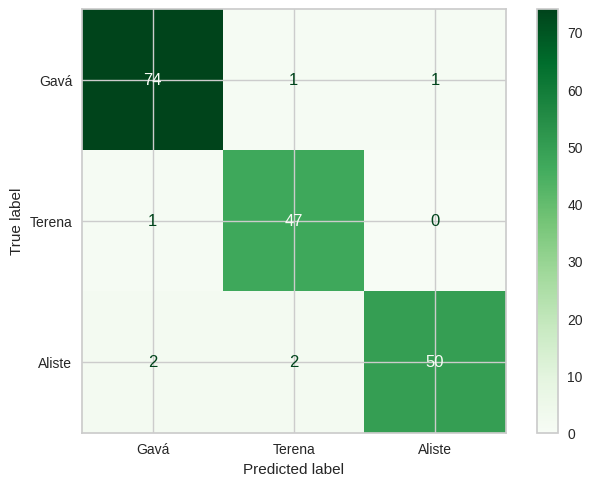

In [16]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= ['Gavá', 'Terena', 'Aliste'])
disp.plot(cmap='Greens')
plt.savefig("/home/dsg/vortex/PRODUCTION/outputs/plots/ConfMatrixFvs.png",bbox_inches='tight')


### Save the Model
This function saves the transformation pipeline and trained model object into the current working directory as a pickle file for later use.

In [17]:
save_model(final_model, model_name = '/home/dsg/vortex/PRODUCTION/outputs/models/VortexCalibrated',verbose=True)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Al', 'Si', 'P', 'S', 'Cl', 'K',
                                              'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn',
                                              'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga',
                                              'Ge', 'As', 'Se', 'Br', 'Rb', 'Sr',
                                              'Y', 'Zr', 'Nb', 'Mo', 'Ru',...
                                                                          class_weight='balanced',
                                                                          criterion='entropy',
                                                                          max_depth=